# Decoding Song Popularity on Spotify
### 🎯 Objective
To understand the key factors influencing a song’s popularity on Spotify and provide actionable insights to improve song recommendations and discoverability of trendy music.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
sns.set(style='whitegrid')

## Functions

In [ ]:
# Function to read Excel file with multiple tabs into a dictionary of DataFrames
def read_excel_multi_tab(file_path):
    xls = pd.ExcelFile(file_path)
    return {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

# Function to convert text month to integer
def convert_month_to_int(df, month_col):
    if df[month_col].dtype == 'object':
        df[month_col] = df[month_col].astype(str).str.strip()
        df[month_col] = pd.to_datetime(df[month_col], format='%B', errors='coerce') \
                       .dt.month.fillna(df[month_col].astype(float, errors='ignore')).astype(int)
    return df

# Function to create date, age, and quarter columns
def create_date_features(df):
    df['release_date'] = pd.to_datetime({'year': df['released_year'],
                                         'month': df['released_month'],
                                         'day': df['released_day']})
    df['song_age_days'] = (pd.Timestamp.now() - df['release_date']).dt.days
    df['release_quarter'] = df['release_date'].dt.quarter
    return df

# Function to prepare song dataset
def prepare_data(song_details):
    song_details['Song_Id'] = song_details['Song_Id'].astype(str).str.replace(',','').astype(int)
    song_details['streams'] = pd.to_numeric(song_details['streams'], errors='coerce')
    song_details = convert_month_to_int(song_details, 'released_month')
    song_details = create_date_features(song_details)
    return song_details

# Function to join datasets
def join_data(song_details, node_details):
    df_merged = pd.merge(song_details, node_details, on='Song_Id', how='inner')
    return df_merged

def update_release_date(df, song_id, year=None, month=None, day=None):
    idx = df[df['Song_Id'] == song_id].index
    df.loc[idx, 'released_year'] = year
    df.loc[idx, 'released_month'] = month
    df.loc[idx, 'released_day'] = day

# Impute missing values in given features using median values from same artist(s).
def impute_by_artist_median(df, features, artist_col='artist(s)_name', id_col='Song_Id'):
    artist_df = df[[id_col, artist_col] + features].copy()
    artist_df['artist'] = artist_df[artist_col].str.split(', ')
    artist_df = artist_df.explode('artist')

    artist_medians = artist_df.groupby('artist')[features].median().reset_index()

    exploded = df[[id_col, artist_col]].copy()
    exploded['artist'] = exploded[artist_col].str.split(', ')
    exploded = exploded.explode('artist')

    exploded = exploded.merge(artist_medians, on='artist', how='left')

    song_medians = exploded.groupby(id_col)[features].max().reset_index()

    for feature in features:
        df = df.merge(song_medians[[id_col, feature]], on=id_col, how='left', suffixes=('', '_artist_median'))
        df[feature] = df[feature].fillna(df[f'{feature}_artist_median'])
        df.drop(columns=[f'{feature}_artist_median'], inplace=True)

        # Fallback: fill with global median if still missing
        df[feature] = df[feature].fillna(df[feature].median())

    return df

    # Function to plot distributions and interactions
def plot_features(df, cols, plt_type):
    r, c = 4, 5

    fig, axes = plt.subplots(r, c, figsize=(20, r * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        if i < len(axes):
            if plt_type == 'hist':
                sns.histplot(df[col], kde=True, ax=axes[i])
                axes[i].set_title(f"{col}")
            else:
                sns.boxplot(df[col], ax= axes[i])
                axes[i].set_title(f"{col}")

    plt.tight_layout()
    plt.show()

def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

## 1. Dataset Overview
Load and display the initial dataset.

In [ ]:
# root = Path().parent

file_path = "/content/spotify/Song_Dataset.xlsx"
dfs = read_excel_multi_tab(file_path)

songs_df = pd.DataFrame(dfs['Song_Deatils'])
node_df = pd.DataFrame(dfs['Node_Deatils'])
data_dict = pd.DataFrame(dfs['Data Dictionary'])
print(songs_df.shape)
#songs_df.head()
print(node_df.shape)
#node_df.head()

(949, 18)
(954, 8)


## 2. Data Cleaning & Preprocessing


In [ ]:
songs_df.info()
songs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Song_Id               949 non-null    object 
 1   track_name            949 non-null    object 
 2   artist(s)_name        949 non-null    object 
 3   artist_count          949 non-null    int64  
 4   released_year         949 non-null    int64  
 5   released_month        949 non-null    object 
 6   released_day          949 non-null    int64  
 7   in_spotify_playlists  949 non-null    int64  
 8   in_spotify_charts     949 non-null    int64  
 9   streams               949 non-null    object 
 10  in_apple_playlists    949 non-null    int64  
 11  in_apple_charts       949 non-null    int64  
 12  in_deezer_playlists   949 non-null    int64  
 13  in_deezer_charts      949 non-null    int64  
 14  in_shazam_charts      898 non-null    float64
 15  bpm                   9

,Song_Id,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode
0,"4,137",Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826.0,125,B,Major
1,"3,628",LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382.0,92,C#,Major
2,"3,520",vampire,Olivia Rodrigo,1,2023,June,30,1397,113,140003974,94,207,91,14,949.0,138,F,Major
3,"3,362",Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548.0,170,A,Major
4,"3,914",WHERE SHE GOES,Bad Bunny,1,2025,May,18,3133,50,303236322,84,133,87,15,425.0,144,A,Minor


Need to transform and correct data types for Song_Id, released_month, streams.
Also, since released_month has mix of integer and name values for month, they need to be converted to numeric for consistency.
There are two categorical predictor columns - key and mode, which would need to be encoded.

In [ ]:
# songs_df['streams'] = pd.to_numeric(songs_df['streams'])

The error tells us that there is a string at position 570, which can be verified by-
*songs_df.loc[570,'streams']*
The value has no information about the number of streams and since streams is the column of interest, I decided to drop the row.

In [ ]:
songs_df.drop(index=570, inplace=True)
songs_df.reset_index(drop=True, inplace=True)

In [ ]:
# check data type for node details
node_df.info()
node_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Song_Id             954 non-null    int64  
 1   danceability_%      906 non-null    float64
 2   valence_%           906 non-null    float64
 3   energy_%            907 non-null    float64
 4   acousticness_%      907 non-null    float64
 5   instrumentalness_%  906 non-null    float64
 6   liveness_%          906 non-null    float64
 7   speechiness_%       906 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 59.8 KB


,Song_Id,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,3788,81.0,97.0,77.0,75.0,0.0,35.0,3.0
1,4709,91.0,97.0,57.0,38.0,0.0,40.0,29.0
2,4087,86.0,97.0,80.0,36.0,0.0,9.0,6.0
3,2258,70.0,97.0,62.0,47.0,0.0,10.0,NaN
4,3911,70.0,NaN,59.0,55.0,0.0,27.0,12.0


The data types for node_df seem fine. However, there are missing values which need to be imputed.

In [ ]:
# check for duplicates
# dropped duplicate rows with same values across columns in both song and node dfs
print(f'The original number of rows in songs and node dfs are {songs_df.shape[0]} and {node_df.shape[0]}, resp.')
songs_df.drop_duplicates(inplace=True)
node_df.drop_duplicates(inplace=True)
print(f'The number of rows in songs and node dfs after removing complete duplicates are {songs_df.shape[0]} and {node_df.shape[0]}, resp.')

The original number of rows in songs and node dfs are 948 and 954, resp.
The number of rows in songs and node dfs after removing complete duplicates are 940 and 944, resp.


In [ ]:
#check rows having duplicate track_name
songs_df[songs_df.duplicated(['track_name','artist(s)_name'], keep=False)]
songs_df[songs_df.duplicated(['track_name'], keep=False)]

,Song_Id,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode
12,"3,510",Flowers,Miley Cyrus,1,2023,January,12,12211,115,1316855716,300,215,745,58,1021.0,118,NaN,Major
13,"4,275",Daylight,David Kushner,1,2023,April,14,3528,98,387570742,80,156,182,24,1281.0,130,D,Minor
54,"2,749",Die For You,The Weeknd,1,2016,November,24,2483,59,1647990401,68,21,24,0,259.0,134,C#,Minor
174,"2,950",SNAP,Rosa Linn,1,2022,March,19,3202,18,726307468,148,80,226,24,0.0,170,NaN,Major
327,"3,817",Numb,Linkin Park,1,2003,3,24,20111,5,1361425037,39,0,7341,0,0.0,110,A,Major
331,"2,244",Miss You,"Robin Schulz, Oliver Tree",2,2022,August,5,5730,10,497225336,108,16,197,3,165.0,145,F#,Minor
341,"2,321",SPIT IN MY FACE!,ThxSoMch,1,2022,October,31,629,14,303216294,32,3,9,0,0.0,94,G#,Major
368,"4,601",About Damn Time,Lizzo,1,2022,7,15,2332,2,723894473,0,0,25,0,0.0,109,A#,Minor
413,"3,672",Die For You,Joji,1,2022,11,4,1703,0,246390068,38,45,36,16,0.0,148,G#,Major
444,"4,917",Let It Snow! Let It Snow! Let It Snow!,Dean Martin,1,1959,11,16,6512,0,446390129,88,1,277,0,0.0,134,C#,Major


There are some rows having same track_name but different artists which can be the case in real world. So, no action taken.
There are some rows with both track and artist name matching, which on first glance looked suspicious. However, on further checking seem valid as sometimes songs are re-released or have an explicit and a censored version.

In [ ]:
# check for duplicate rows based on Song_Id
duplicate_songs = songs_df[songs_df.duplicated(['Song_Id'], keep=False)]
print(duplicate_songs.shape)

duplicate_nodes = node_df[node_df.duplicated('Song_Id', keep=False)]
print(duplicate_nodes.shape)

(243, 18)
(243, 8)


There is a lot of uncertainty in joining these duplicate rows as no definite key/logic available.
These can be joined 1-1 under the assumption that the order of the duplicate Song_Id in both dfs is same.
OR
The other option is to group and compute a central value for the features in node_df and then use the aggregated values for the corresponding songs based on Song_Id. However, this may produce spurios results.
For the above reasons, I am dropping all the rows where Song_Id appears more than once in songs_df.

For the node_df, I am deduplicating by keeping the last row.

In [ ]:
songs_df = songs_df[songs_df['Song_Id'].duplicated(keep=False) == False]

node_df = node_df.drop_duplicates('Song_Id', keep='last')

3 of the rows in songs_df had incorrect values for released_year. The release date column when created had future dates. Since I was able to verify the release dates for these songs from the internet, I manually updated the dates as below.

In [ ]:
update_release_date(songs_df, '3,914', 2023, 5, 18)
update_release_date(songs_df, '3,708', 2023, 5, 12)
update_release_date(songs_df, '3,230', 2023, 6, 1)

I created functions as below:
- to convert Song_Id to integer by first replacing the comma and then casting as int
- to convert streams to numeric data type
- to convert released_month to integer checking for the mixed values
- and created date features such as release_date, age in days for each song, and release_quarter

In [ ]:
songs_df = prepare_data(songs_df)

<ipython-input-50-cf766800fa6a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_details['Song_Id'] = song_details['Song_Id'].astype(str).str.replace(',','').astype(int)
<ipython-input-50-cf766800fa6a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_details['streams'] = pd.to_numeric(song_details['streams'], errors='coerce')
<ipython-input-50-cf766800fa6a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Then joined the two dataframes

In [ ]:
df_merged = join_data(songs_df, node_df)
df_merged.shape
#merged_duplicates = df_merged[df_merged.duplicated(['Song_Id'], keep=False)]
#songs_df[~songs_df.Song_Id.isin(df_merged.Song_Id)]

(693, 28)

The popularity of the Artist also play a huge role in influencing song popularity when released and adoption. With this rationale, I wanted to create a feature which would rank artists by average streams and assign a score.
Firstly, I had hard-coded the Top 5, 10, 20, ... categories.
But, later, I classified artists by popularity without hard-coding rank thresholds.

In [ ]:
artist_df = df_merged[['Song_Id','artist(s)_name','streams']]
artist_df_exp = artist_df.assign(artist=artist_df['artist(s)_name'].str.split(', ')).explode('artist')

artist_stats = artist_df_exp.groupby('artist', as_index=False)['streams'].agg(['mean']).reset_index(drop=True)
artist_stats.columns = ['artist', 'avg_streams']
# artist_stats['rank'] = artist_stats['avg_streams'].rank(method='min', ascending=False).astype(int)

# def assign_points(rank):
#     if rank <= 5:
#         return 25
#     elif rank <= 10:
#         return 18
#     elif rank <= 20:
#         return 15
#     elif rank <= 50:
#         return 6
#     elif rank <= 100:
#         return 3
#     else:
#         return 1

# artist_stats['points'] = artist_stats['rank'].apply(assign_points)

artist_stats['points'] = pd.qcut(
    artist_stats['avg_streams'],
    q=[0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    labels=[0, 1, 2, 3, 4, 5]
).astype(int)

artist_df_exp = artist_df_exp.merge(artist_stats[['artist','points']], on='artist', how='left')

artist_df = artist_df_exp.groupby('Song_Id')['points'].max().reset_index()

df_merged = df_merged.merge(artist_df, on='Song_Id', how='left')

<ipython-input-64-07f6009a05a4>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_avg_streams, x='Artist Class', y='avg_streams', palette='viridis', order=['Top 1%', 'Top 5%', 'Top 10%', 'Top 20%', 'Top 50%', 'Others'])


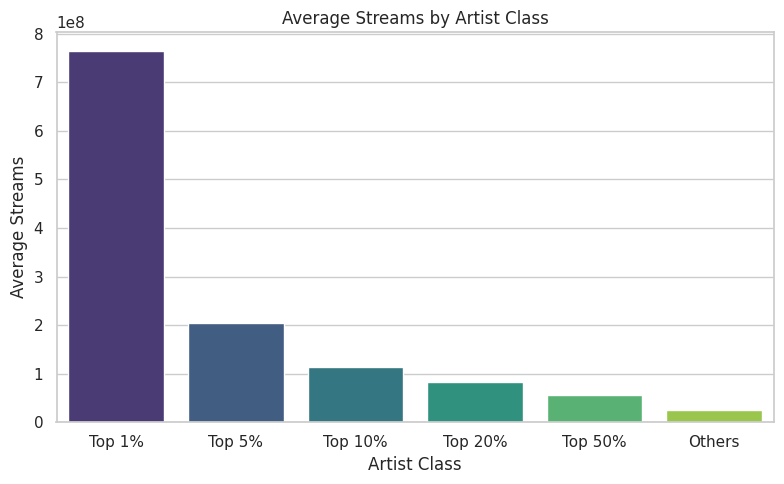

In [ ]:
points_labels = {
    5: 'Top 1%',
    4: 'Top 5%',
    3: 'Top 10%',
    2: 'Top 20%',
    1: 'Top 50%',
    0: 'Others'
}
class_avg_streams = artist_stats.groupby('points', as_index=False)['avg_streams'].mean()
class_avg_streams['Artist Class'] = class_avg_streams['points'].map(points_labels)

plt.figure(figsize=(8, 5))
sns.barplot(data=class_avg_streams, x='Artist Class', y='avg_streams', palette='viridis', order=['Top 1%', 'Top 5%', 'Top 10%', 'Top 20%', 'Top 50%', 'Others'])
plt.title('Average Streams by Artist Class')
plt.ylabel('Average Streams')
plt.xlabel('Artist Class')
plt.tight_layout()
plt.show()

**Impute Values for columns with missing values**



Check missing values as below

In [ ]:
df_merged.info()
missing_percent = df_merged.isnull().mean() * 100
missing_cols = missing_percent[missing_percent > 0].sort_values(ascending=False)
missing_cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Song_Id               693 non-null    int64         
 1   track_name            693 non-null    object        
 2   artist(s)_name        693 non-null    object        
 3   artist_count          693 non-null    int64         
 4   released_year         693 non-null    int64         
 5   released_month        693 non-null    int64         
 6   released_day          693 non-null    int64         
 7   in_spotify_playlists  693 non-null    int64         
 8   in_spotify_charts     693 non-null    int64         
 9   streams               693 non-null    int64         
 10  in_apple_playlists    693 non-null    int64         
 11  in_apple_charts       693 non-null    int64         
 12  in_deezer_playlists   693 non-null    int64         
 13  in_deezer_charts    

,0
key,9.956710
in_shazam_charts,5.483405
danceability_%,5.339105
valence_%,5.194805
energy_%,5.194805
liveness_%,5.194805
instrumentalness_%,5.050505
speechiness_%,4.906205
acousticness_%,4.473304


Since the missing values are less than 10%, I will impute the missing values.

In [ ]:
df_merged['in_shazam_charts'] = df_merged['in_shazam_charts'].fillna(0)

Filled 'in_shazam_charts' with 0 as it is not necessary for all songs to be in charts.


**Imputing values for key**

Converting key to numeric using Chromatic Scale Mapping (12-tone scale)

In [ ]:
key_map = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3,
    'E': 4, 'F': 5, 'F#': 6, 'G': 7,
    'G#': 8, 'A': 9, 'A#': 10, 'B': 11
}
df_merged['key'] = df_merged['key'].str.strip().map(key_map)

unmapped = df_merged['key'].isna().sum()
print(f"Unmapped keys after conversion: {unmapped}")
df_merged[df_merged['key'].isna()].head()

Unmapped keys after conversion: 69


,Song_Id,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,...,song_age_days,release_quarter,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,points
9,3510,Flowers,Miley Cyrus,1,2023,1,12,12211,115,1316855716,...,817,1,71.0,65.0,68.0,6.0,0.0,3.0,7.0,5
25,2331,Los del Espacio,"Big One, Duki, Lit Killah, Maria Becerra, FMK,...",8,2023,6,1,1150,31,123122413,...,677,2,81.0,63.0,68.0,11.0,0.0,11.0,4.0,4
33,3099,I Ain't Worried,OneRepublic,1,2022,5,13,8431,76,1085685420,...,1061,2,71.0,82.0,81.0,11.0,0.0,6.0,5.0,5
43,3414,cardigan,Taylor Swift,1,2020,7,24,7923,29,812019557,...,1719,3,61.0,NaN,58.0,55.0,0.0,27.0,4.0,5
86,3019,Por las Noches,Peso Pluma,1,2021,6,11,457,24,330346424,...,1397,2,81.0,39.0,60.0,31.0,0.0,7.0,3.0,4


Features of the node_df with missing values imputed based on aggregate median values by for an artist.
Imputing missing values like key, danceability_%, etc., based on median values for the same artist(s) adds musical intelligence to the cleaning process.

In [ ]:
features_to_impute = [
    'key','danceability_%', 'valence_%', 'energy_%',
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'
]
df_merged = impute_by_artist_median(df_merged, features_to_impute)

The categorical column Mode encoded as below.

In [ ]:
mode_map = {'Minor': 0, 'Major': 1}
df_merged['mode'] = df_merged['mode'].map(mode_map)

Also, created two new features as below. The below columns encompass the value provided by multiple playlist and chart columns.

In [ ]:
pl_chart_columns_incl_spotify = [
    'in_spotify_playlists', 'in_spotify_charts',
    'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts'
]
df_merged['avg_in_charts_incl_spotify'] = df_merged[pl_chart_columns_incl_spotify].mean(axis=1)

pl_chart_columns_excl_spotify = [
    'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts'
]
df_merged['avg_in_charts_excl_spotify'] = df_merged[pl_chart_columns_excl_spotify].mean(axis=1)

## 3. Exploratory Data Analysis (EDA)
### 📊 Correlation Heatmap

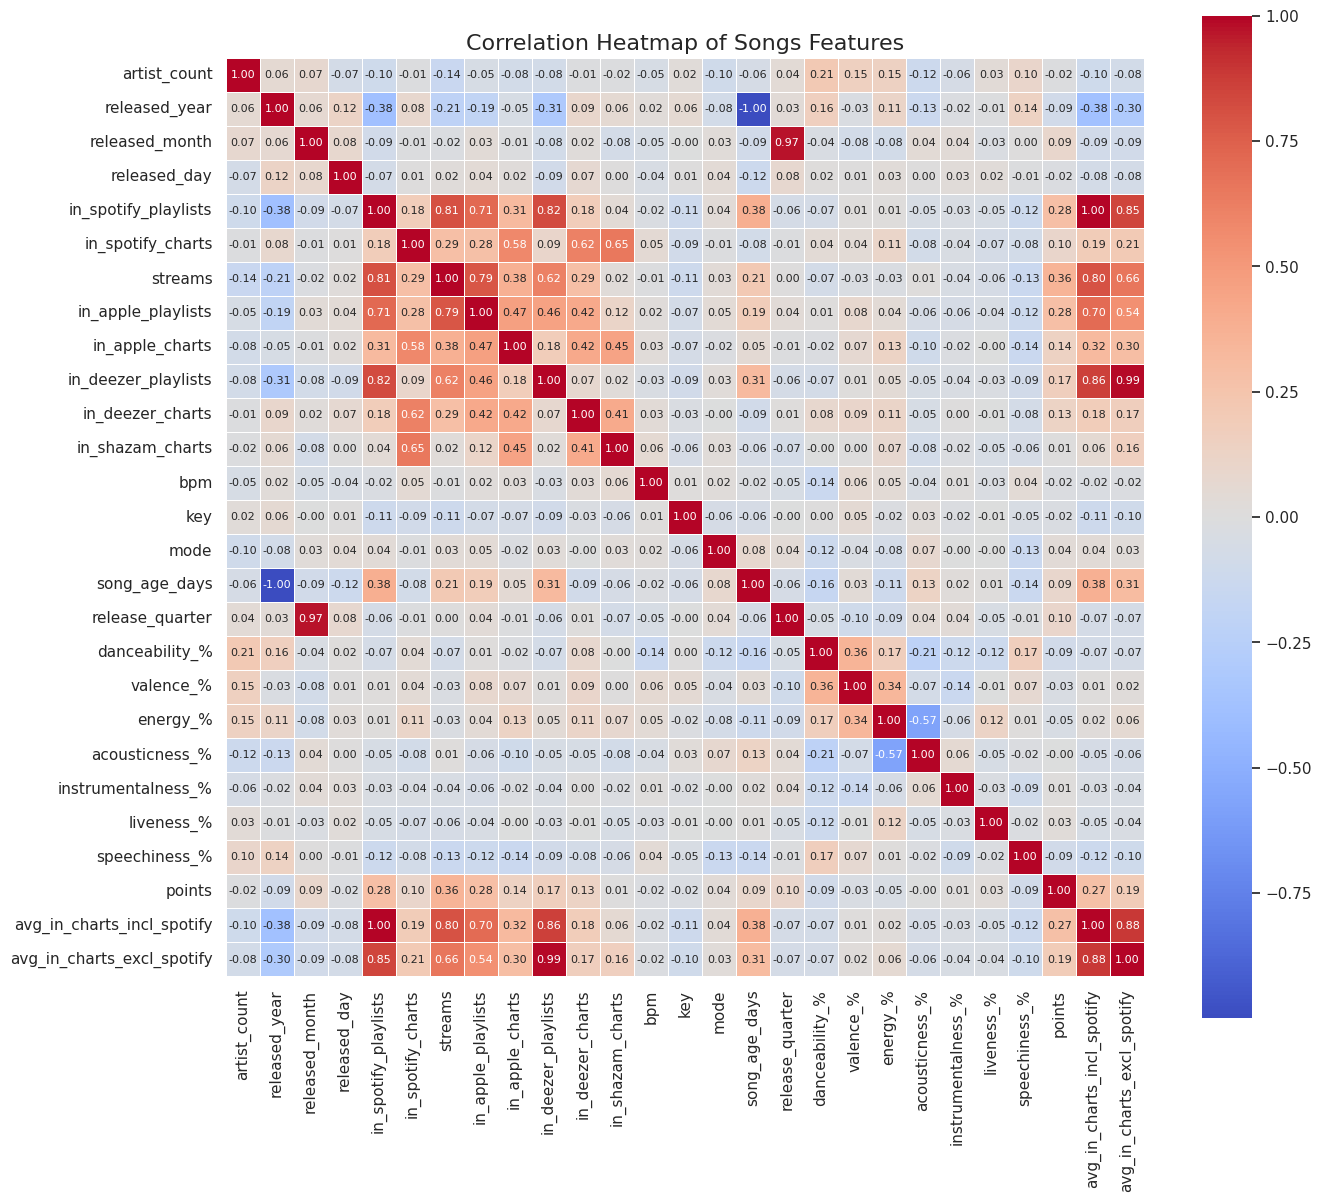

In [ ]:
df_merged.columns
cols_of_interest = ['artist_count', 'released_year', 'released_month', 'released_day',
       'in_spotify_playlists', 'in_spotify_charts', 'streams',
       'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
       'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode',
       'song_age_days', 'release_quarter', 'danceability_%',
       'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
       'liveness_%', 'speechiness_%', 'points', 'avg_in_charts_incl_spotify', 'avg_in_charts_excl_spotify']
corr_matrix = df_merged[cols_of_interest].corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"fontsize":8})
plt.title('Correlation Heatmap of Songs Features', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
desc_summary = df_merged.describe()
desc_summary

,Song_Id,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,points,avg_in_charts_incl_spotify,avg_in_charts_excl_spotify
count,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,6.930000e+02,693.000000,693.000000,...,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,3427.708514,1.580087,2018.430014,6.059163,13.987013,5408.331890,11.896104,5.311456e+08,71.927850,53.370851,...,66.155844,50.178211,64.326840,27.019481,1.897547,18.159452,9.993506,4.578644,858.814059,118.294084
min,2000.000000,1.000000,1930.000000,1.000000,1.000000,34.000000,0.000000,2.762000e+03,0.000000,0.000000,...,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000,1.000000,4.857143,0.000000
25%,2678.000000,1.000000,2020.000000,3.000000,6.000000,892.000000,0.000000,1.413817e+08,14.000000,8.000000,...,56.000000,31.000000,53.000000,6.000000,0.000000,10.000000,4.000000,4.000000,149.000000,13.800000
50%,3432.000000,1.000000,2022.000000,6.000000,13.000000,2308.000000,3.000000,3.010517e+08,37.000000,41.000000,...,67.000000,51.000000,65.000000,18.000000,0.000000,13.000000,6.000000,5.000000,363.714286,36.000000
75%,4145.000000,2.000000,2022.000000,9.000000,22.000000,6135.000000,16.000000,6.846758e+08,101.000000,89.000000,...,77.000000,68.000000,77.000000,41.000000,0.000000,23.000000,11.000000,5.000000,939.428571,97.800000
max,4997.000000,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,...,96.000000,96.000000,97.000000,97.000000,91.000000,90.000000,64.000000,5.000000,8988.142857,2583.400000
std,857.626168,0.928674,10.804614,3.571437,9.213028,8059.922323,19.716287,5.888624e+08,91.190935,50.909101,...,14.381425,22.939092,16.335832,25.577435,9.575206,12.690293,9.605117,0.772508,1309.016239,253.702247


**Plot numeric features**

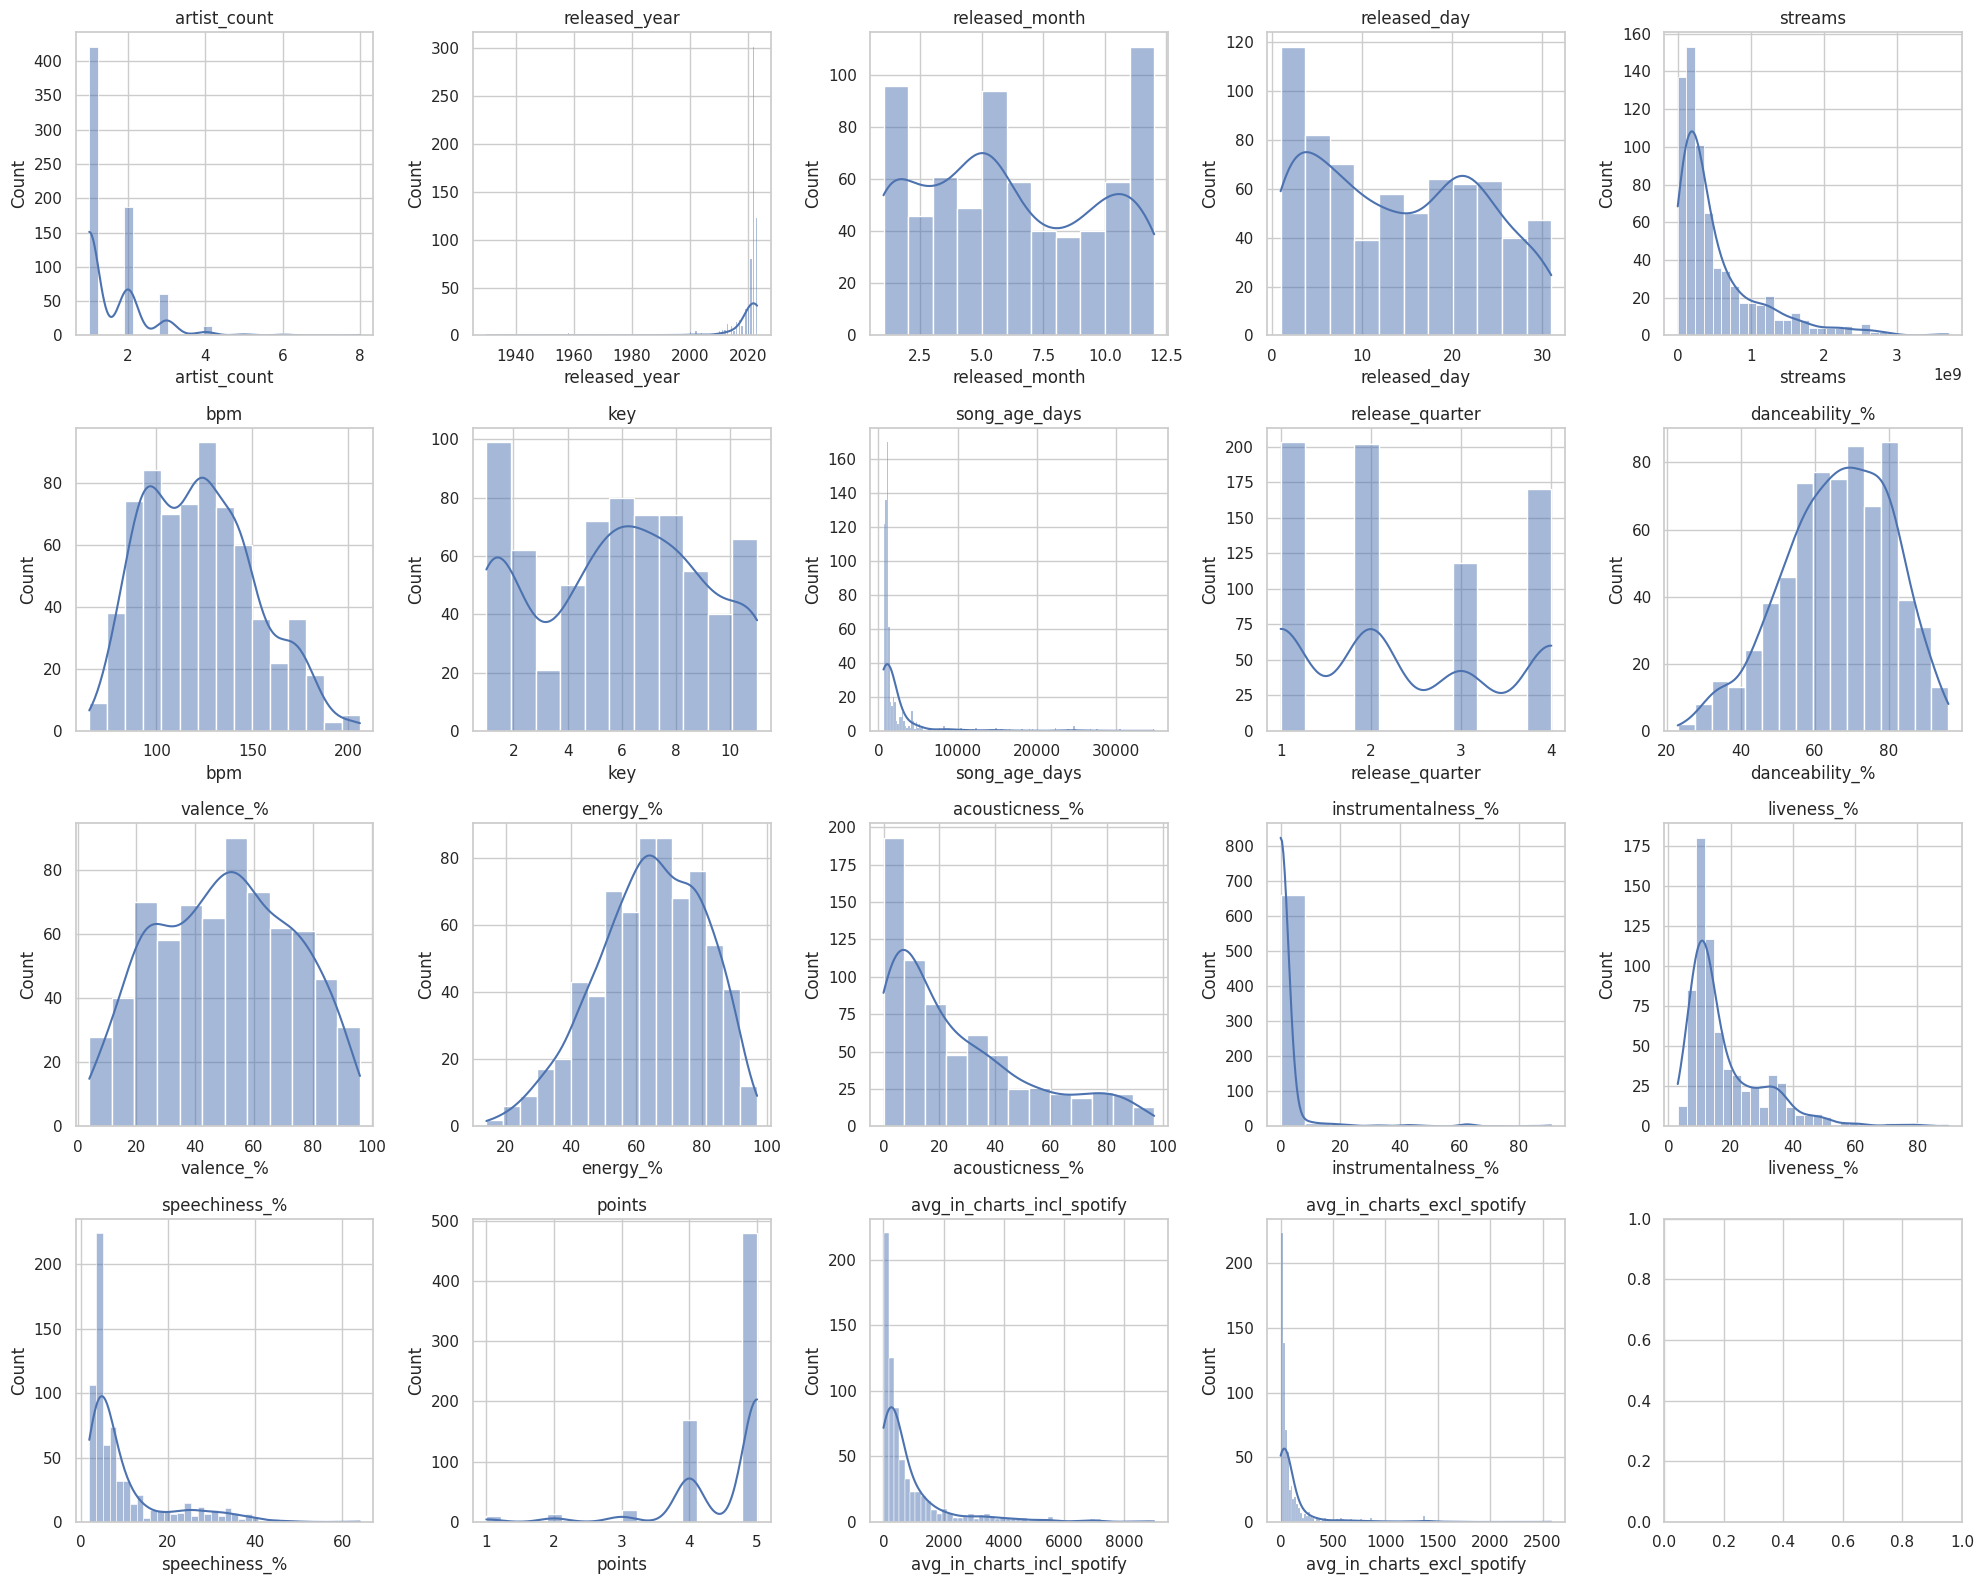

In [ ]:
cols_of_interest = ['artist_count', 'released_year', 'released_month', 'released_day',
       'streams', 'bpm', 'key',
       'song_age_days', 'release_quarter', 'danceability_%',
       'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
       'liveness_%', 'speechiness_%', 'points', 'avg_in_charts_incl_spotify', 'avg_in_charts_excl_spotify']
plot_features(df_merged, cols_of_interest, 'hist')

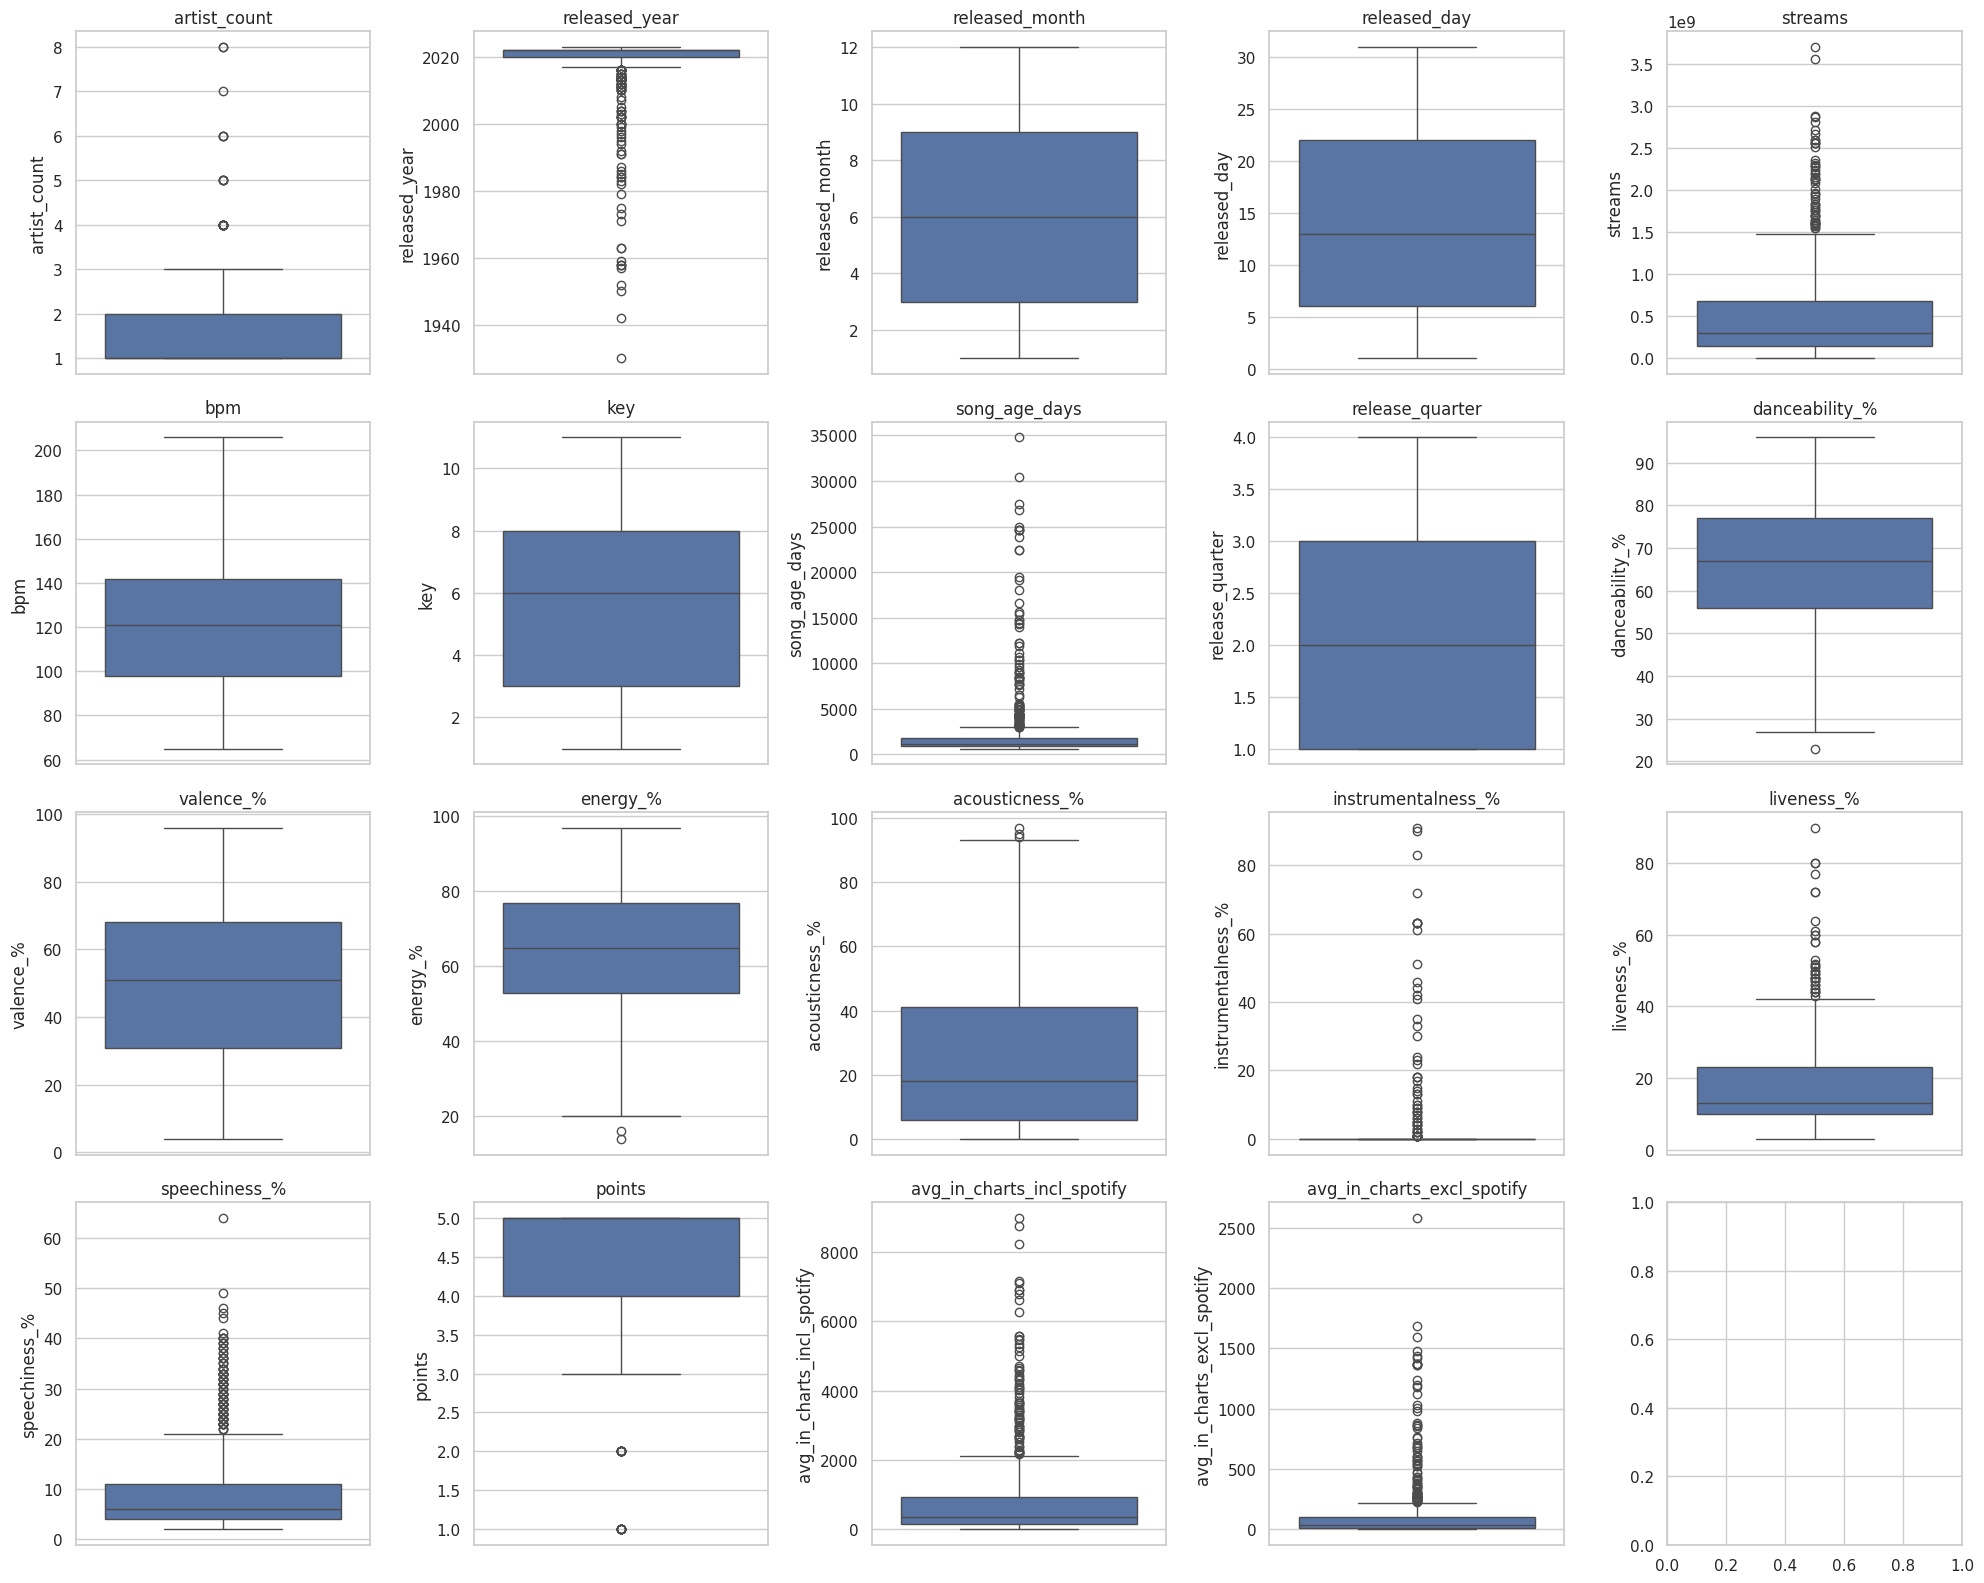

In [ ]:
plot_features(df_merged, cols_of_interest, 'box')

Many of the columns are right skewed, which is why I applied PowerTransformation to handle that.
Also, I observed that streams has outliers and it being the target, outlier correction is necessary to avoid bad results. Clipped the outliers for streams.

In [ ]:
streams_lower, streams_upper = detect_iqr_outliers(df_merged['streams'])

print(f"Streams outlier thresholds: {streams_lower:.2f}, {streams_upper:.2f}")
print(f"Original streams outliers: {(df_merged['streams'] > streams_upper).sum()}")

df_merged['streams'] = df_merged['streams'].clip(lower=streams_lower, upper=streams_upper)

Streams outlier thresholds: -673559463.50, 1499616980.50
Original streams outliers: 54


Applied PowerTransformer to correct for skewness. Also, helps with standardization.

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


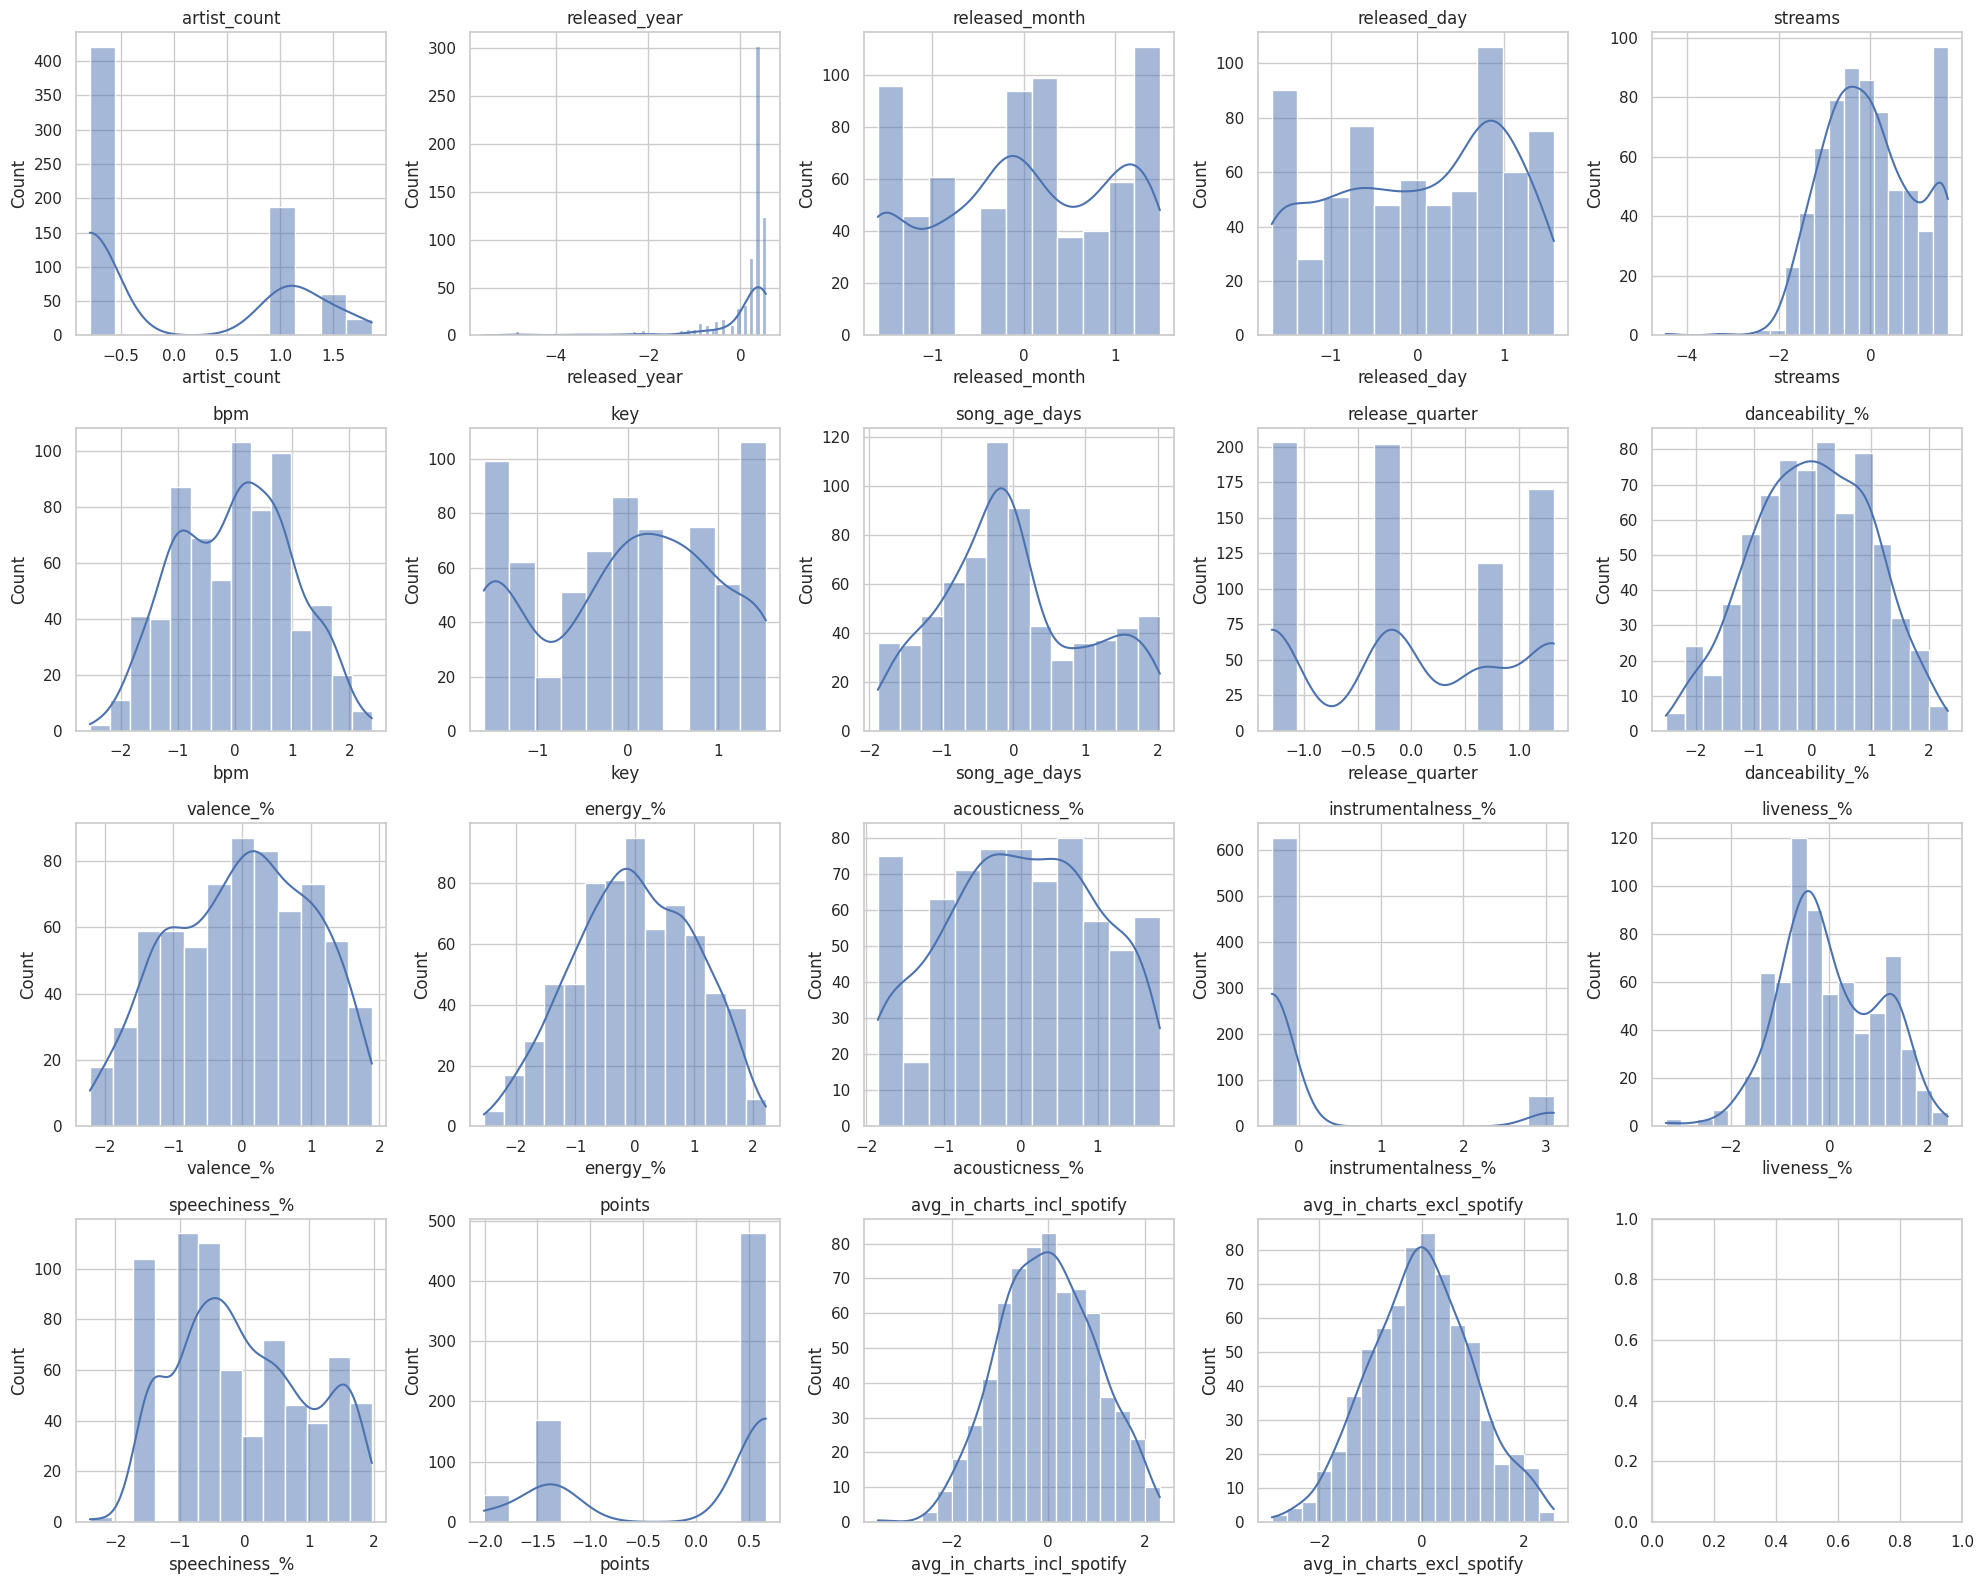

In [ ]:
pt = PowerTransformer(method='yeo-johnson',standardize=True)
arr_transformed = pt.fit_transform(df_merged[cols_of_interest])
df_transformed = pd.DataFrame(arr_transformed, columns=cols_of_interest)
df_transformed = pd.concat([df_transformed, df_merged[['mode']]], axis=1)

plot_features(df_transformed, cols_of_interest, 'hist')

#plot_features(df_transformed, cols_of_interest, 'box')

# df_log = np.log1p(df_merged[cols_of_interest])
# plot_features(df_log, cols_of_interest, 'hist')

PowerTransformer performed much better in removing the skewness

## 5. Model Performance Evaluation

In [ ]:
# removed to avoid multicollinearity - 'released_year', 'released_month'
# features = ['artist_count', 'released_day',
#      'bpm', 'key', 'mode', 'song_age_days', 'release_quarter',
#      'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
#      'liveness_%', 'speechiness_%', 'points']

features = ['artist_count', 'released_day',
     'bpm', 'key', 'mode', 'release_quarter',
     'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
     'liveness_%', 'speechiness_%', 'points']
target = 'streams'

X = df_transformed[features]
y = df_transformed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [2, 5]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred_on_train = best_rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_on_train)
print(f"Train MSE: {mse_train:.2f}")

y_pred = best_rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Best Model: {grid_search.best_params_}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Test R² Score: {r2_test:.4f}")

In [ ]:
importances = best_rf.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15], palette='viridis')
plt.title('Top 15 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 6. Feature Engineering

In [ ]:
def create_feature_combinations(df, feature_cols, degree=2, interaction_only=False):

    poly = PolynomialFeatures(
        degree=degree,
        interaction_only=interaction_only,
        include_bias=False
    )

    features_arr = df[feature_cols].values
    poly_features = poly.fit_transform(features_arr)
    poly_feature_names = poly.get_feature_names_out(feature_cols)

    # Create a DataFrame of the new features
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    return df_poly

features = ['artist_count', 'bpm', 'key', 'mode', 'song_age_days', 'release_quarter',
     'danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
     'liveness_%', 'speechiness_%', 'points']
target = 'streams'
df_poly = create_feature_combinations(df_transformed, features, degree=2, interaction_only=False)

# Combine back with target variable for modeling
df_model_ready = pd.concat([df_poly, df_transformed[['streams']]], axis=1)

X = df_model_ready.drop(columns=['streams'])
y = df_model_ready['streams']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [750],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred_on_train = best_rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_on_train)
print(f"Train MSE: {mse_train:.2f}")

y_pred = best_rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Best Model: {grid_search.best_params_}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Test R² Score: {r2_test:.4f}")

importances = best_rf.feature_importances_
feature_names = X.columns

# Create DataFrame and sort
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

## 7. Retraining using Top Features from Feature Engineering


In [ ]:
top_n = 10
top_features = feat_imp.head(top_n)['feature'].tolist()

X_top = X[top_features]

X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

rf_top = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [750],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=rf_top, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train_top, y_train)
best_rf = grid_search.best_estimator_

y_pred_on_train = best_rf.predict(X_train_top)
mse_train = mean_squared_error(y_train, y_pred_on_train)
print(f"Train MSE: {mse_train:.2f}")

y_pred = best_rf.predict(X_test_top)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Best Model: {grid_search.best_params_}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Test R² Score: {r2_test:.4f}")

importances = best_rf.feature_importances_
feature_names = X_top.columns

# Create DataFrame and sort
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


## 8. Actionable Insights for Spotify

- Prioritize recommending older, artist-backed songs in user suggestions

- Surface danceable tracks from newer artists to increase early traction

- Use release quarter + age to dynamically boost discoverability of seasonal hits

- Focus on acoustic long-tails for playlists that cater to mood-based listening

Top Features Driving Song Popularity on Spotify:

song_age_days (Importance: 0.636)
Older songs tend to accumulate more streams simply due to longevity—but interestingly, it's not a linear growth. This feature alone dominates the prediction, highlighting that time is a major ally for streaming numbers. The longer a song has been out, the more opportunity it has to go viral, feature in playlists, or resurge through trends.

song_age_days x points (0.115)
A cleverly engineered interaction feature. It tells us that the combination of how old a song is and how popular the artist is (via points) dramatically boosts the stream count. In short, a popular artist’s older track has serious staying power.

song_age_days^2 (0.045)
The squared term captures non-linear relationships—i.e., not all old songs perform equally. This helps the model understand that the growth in streams might plateau or spike at certain points.

danceability_% (0.041)
Danceable songs are more likely to be shared, featured in curated lists, and looped by listeners. A toe-tapping track gets traction.

points (0.033)
Direct artist influence. More popular artists (based on stream-weighted classes) consistently drive higher streams, regardless of song characteristics.

song_age_days x release_quarter (0.032)
Songs released in specific quarters (like Q4 for holidays or Q2 for summer) behave differently in their aging pattern. This variable captures that nuance.

points^2 (0.031)
Another nonlinear term—superstars don't just outperform; they outperform exponentially. This makes a case for giving extra weight to elite artists when curating new content.

song_age_days x acousticness_% (0.027)
This interaction shows that older acoustic tracks may gather a dedicated listener base over time.

bpm x key (0.025)
A hybrid of tempo and tonality—certain bpm and key combinations resonate better with mass audiences, influencing how often a song gets added to workout, party, or focus playlists.

mode x song_age_days (0.015)
Whether a song is in a major or minor key, when combined with age, subtly affects listener behavior. For instance, upbeat (major) songs may get more replays over time.

## Conclusion
Through detailed analysis and feature engineering, we uncovered that song age, artist popularity, and danceability are the strongest drivers of song success on Spotify. By modeling complex interactions and incorporating domain knowledge, we built a robust predictive framework that not only forecasts stream counts but also provides actionable insights. These findings can power smarter recommendations, boost user engagement, and help surface potential hits early in their lifecycle. With further refinement and real-time data integration, this approach can evolve into a scalable system for trend forecasting and music curation.